In [2]:
# 2025/12/13
# zhangzhong
# https://docs.langchain.com/oss/python/langgraph/workflows-agents
# 为什么要区分workflow和agent啊，没必要吧

# This guide reviews common workflow and agent patterns.
# - Workflows have predetermined code paths and are designed to operate in a certain order.
# - Agents are dynamic and define their own processes and tool usage.

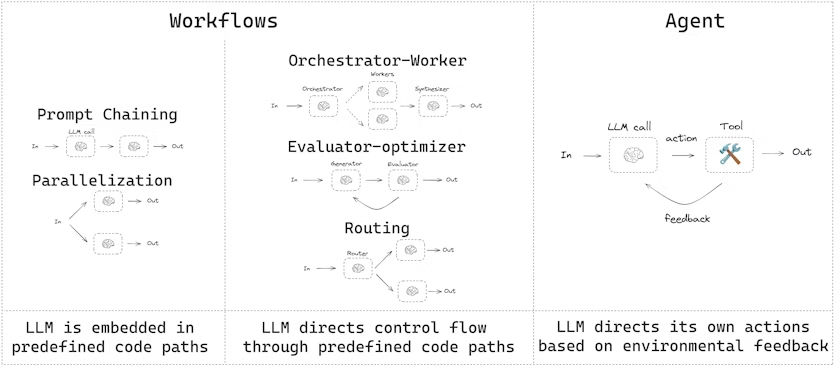

In [4]:
import os
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langchain.messages import AnyMessage, SystemMessage, ToolMessage
from typing_extensions import TypedDict, Annotated
import operator
from typing import Literal
from langgraph.graph import StateGraph, START, END

api_key = os.environ["BIGMODEL_API_KEY"]


llm = ChatOpenAI(
    temperature=0.6,
    model="glm-4.6",
    api_key=api_key,
    base_url="https://open.bigmodel.cn/api/paas/v4/",
)

# LLMs and augmentations
Workflows and agentic systems are based on LLMs and the various augmentations you add to them. 
Tool calling, structured outputs, and short term memory are a few options for tailoring LLMs to your needs.
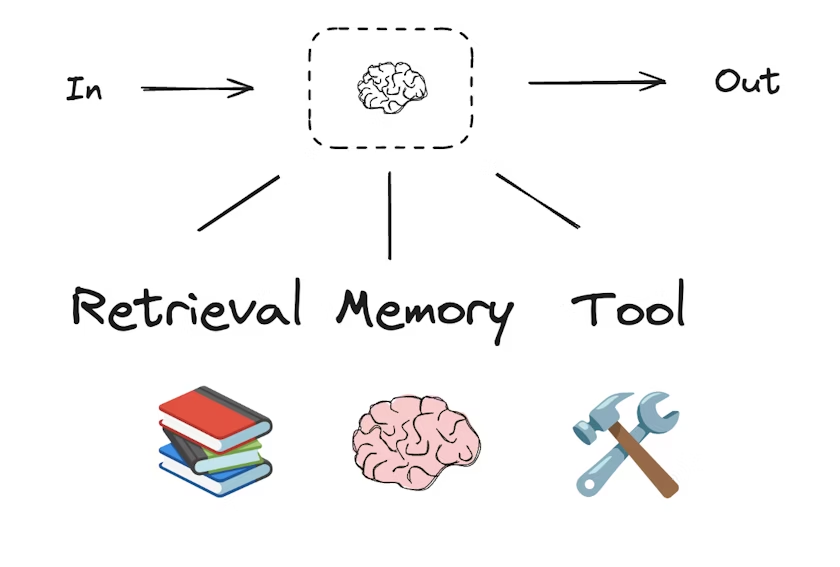

In [ ]:
# Schema for structured output
from pydantic import BaseModel, Field


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
# GLM看起来不支持结构化output，就算把method="function_calling"也不行
structured_llm = llm.with_structured_output(SearchQuery, method="function_calling")

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output)

None


In [7]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_-8074853971099453811',
  'type': 'tool_call'}]

## Prompt Chaining
- Prompt chaining is when each LLM call processes the output of the previous call. 
- It’s often used for performing well-defined tasks that can be broken down into smaller, verifiable steps. 
# Some examples include:
- Translating documents into different languages
- Verifying generated content for consistency
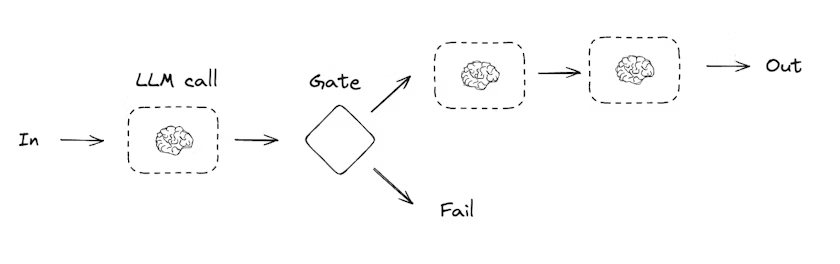

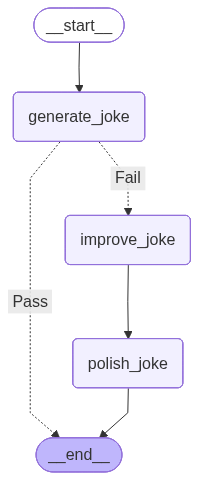

In [10]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [11]:
# Invoke
# - chain的invoke的返回结果也是state
# - 这里的输入也是一个最初的state
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Final joke:")
    print(state["joke"])

Initial joke:

Why do cats make terrible storytellers?

Because they only have one tale

--- --- ---

Final joke:

Why do cats make terrible storytellers?

Because they only have one tale


# Parallelization
With parallelization, LLMs work simultaneously on a task. This is either done by running multiple independent subtasks at the same time, or running the same task multiple times to check for different outputs. Parallelization is commonly used to:
- Split up subtasks and run them in parallel, which increases speed
- Run tasks multiple times to check for different outputs, which increases confidence

Some examples include:
- Running one subtask that processes a document for keywords, and a second subtask to check for formatting errors
- Running a task multiple times that scores a document for accuracy based on different criteria, like the number of citations, the number of sources used, and the quality of the sources 哎，我突然想到可以用多个critics的agent，并发
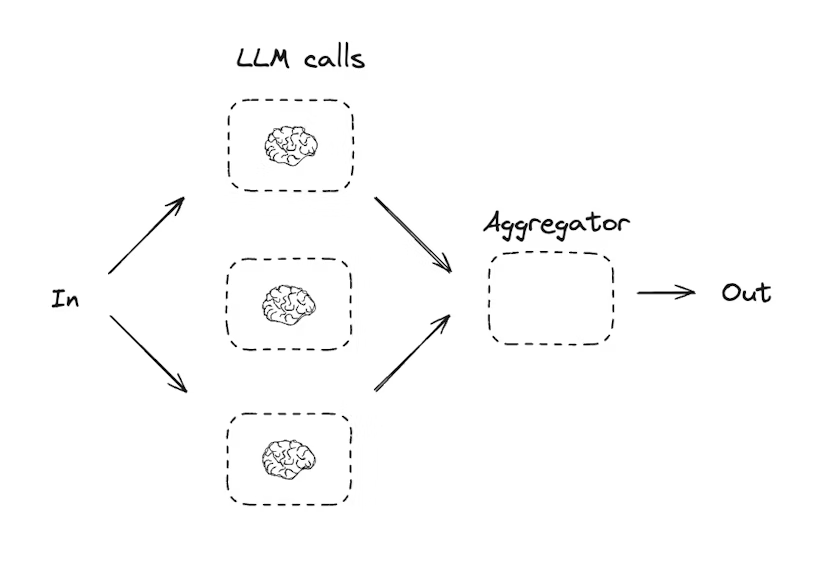

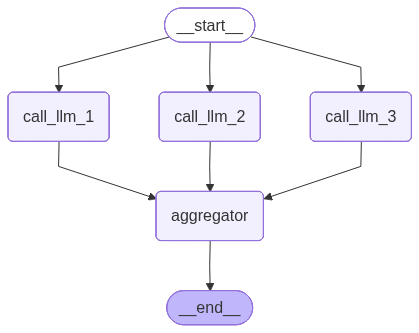

In [12]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

# 看起来langgraph会自动做node之间的sync
def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [ ]:
# Invoke 为什么这么慢呀！好想开启stream看看返回啊
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:

Jasper was a cat of simple, profound pleasures. His world, which he had meticulously mapped and scent-marked over twelve long summers, was perfect. It consisted of the House of the Soft Hands, the Garden of Green Smells, and the Great Warmth that moved across the living room carpet each afternoon.

His Housefolk, a pair of Tall Ones, were adequate providers. They operated the Magic Food Box at the correct times and offered laps of varying softness upon demand. But they were merely background staff in Jasper’s meticulously managed kingdom.

The true heart of his territory was the sunbeam.

Each day, as the light crept over the windowsill, Jasper would position himself within its golden borders. He would close his eyes, letting the heat seep into his bones, and purr. It was a purr of contentment, of authority, of a job well done. He was the King of the Sunbeam, and all was right with the world.

Then came Cleo.

She was a sliver of midn

# Route
Routing workflows process inputs and then directs them to context-specific tasks. This allows you to define specialized flows for complex tasks. For example, a workflow built to answer product related questions might process the type of question first, and then route the request to specific processes for pricing, refunds, returns, etc.
突然想到，其实出不同的题型，也可以是不同的分支的呀，最起码，如果我们用few shot来做，每个分支上的prompt的例题都不一样
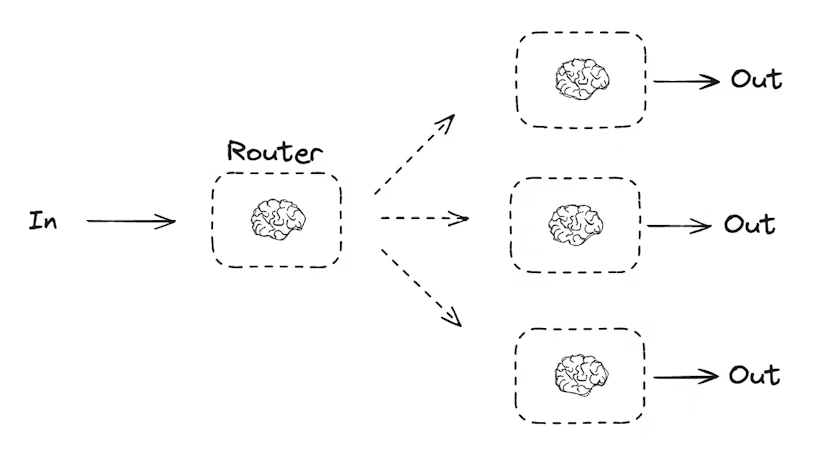

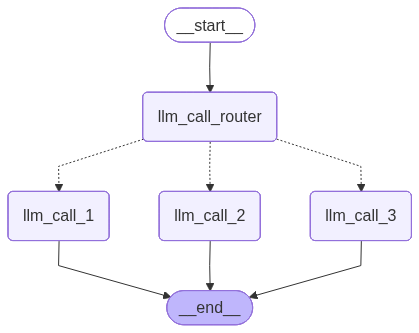

In [14]:
from typing_extensions import Literal
from langchain.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
# TODO：我感觉这里有一些重复，如果note本身知道自己该去往何处的话，也就不需要在这里写了吧
# 或者这里也根本就不需要add_node和add_edge, 每个node自己就是self contained多好啊
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))



In [15]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

ValidationError: 1 validation error for Route
  Invalid JSON: expected value at line 2 column 1 [type=json_invalid, input_value="\nWhat's a cat's favorite dessert?\n\nMice cream", input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/json_invalid

# Orchestrator-worker
In an orchestrator-worker configuration, the orchestrator:
- Breaks down tasks into subtasks
- Delegates subtasks to workers
- Synthesizes worker outputs into a final result
  
Orchestrator-worker workflows provide more flexibility and are often used when subtasks cannot be predefined the way they can with parallelization. This is common with workflows that write code or need to update content across multiple files. For example, a workflow that needs to update installation instructions for multiple Python libraries across an unknown number of documents might use this pattern.
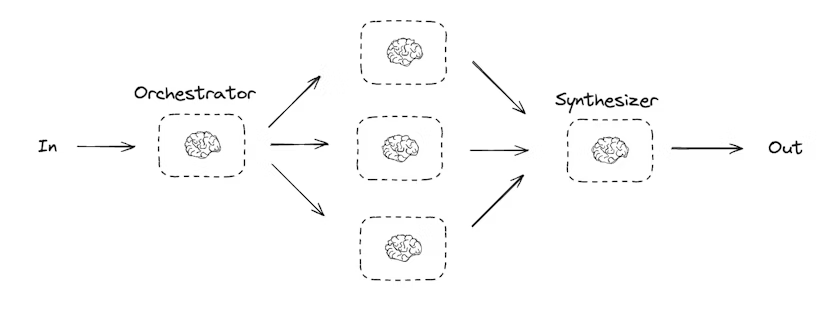

In [17]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
# 先使用大模型做计划
planner = llm.with_structured_output(Sections)

In [ ]:
## workers in langgraph
# Orchestrator-worker workflows are common and LangGraph has built-in support for them.
# The Send API lets you dynamically create worker nodes and send them specific inputs.
# 有点类似 sub graph ? 然后main graph和sub graph之间可以沟通，通过main graph的state
# Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph.
# 果然是这样，这就和structure parallel很像了，就是分配任务，然后gather一下，在main graph的gather处同步
# This gives the orchestrator access to all worker output and allows it to synthesize them into a final output
# 只能迭代吗？不能并发吗？The example below [iterates] over a list of sections and uses the Send API to send a section to each worker.

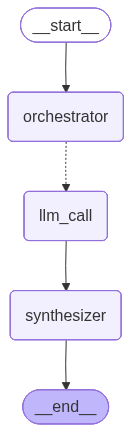

In [ ]:
from langgraph.types import Send


# 这里是在模拟一个report generator
# Graph state
class State(TypedDict):
    topic: str  # Report topic，这里就是要生成的report的topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    # 为什么这里的completed sections是一个list？难道是因为worker是iterative的吗？
    # 应该也只是因为从worker state返回到state，结合起来更加方便
    completed_sections: Annotated[list, operator.add]

# State vs WorkerState:

# State (graph-level) tracks the whole workflow: topic, sections, completed_sections, final_report.
# WorkerState (per worker invocation) is the minimal slice needed by a section writer: section plus completed_sections.
# Both schemas declare completed_sections as Annotated[list, operator.add], so when workers return {"completed_sections": [text]}, LangGraph merges the lists by concatenation. The graph-wide completed_sections starts empty and accumulates one entry per worker; the worker’s completed_sections field is just the output payload used for that merge.


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    # Each Send spawns a llm_call run with its own payload, so multiple workers write sections concurrently.
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Wire edges: plan -> parallel workers -> synthesize
orchestrator_worker_builder.add_edge(START, "orchestrator")
# Conditional edge: assign_workers fans out to one llm_call per section
orchestrator_worker_builder.add_conditional_edges(
    # conditional_edge
    # 第一个参数就是起点的node
    # 第二个参数就是做分支判断的函数，他的返回值就是选择了那个分支
    # 第三个参数目前看起来有两种形式，第一种是kv，k就是分支判断函数的返回值，v就是下一步要走的节点的名字
    # 第三个参数的第二种形式就是这里，是一个list，指的应该就是并行的parallel call，list里面也是节点的名字
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)


# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))



In [19]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown # 竟然还可以展示markdown
Markdown(state["final_report"])

ValidationError: 1 validation error for Sections
  Invalid JSON: expected value at line 2 column 1 [type=json_invalid, input_value='\nOf course. Here is a c... old and new paradigms.', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/json_invalid

# Evaluator optimizer
In evaluator-optimizer workflows, one LLM call creates a response and the other evaluates that response. If the evaluator or a human-in-the-loop determines the response needs refinement, feedback is provided and the response is recreated. This loop continues until an acceptable response is generated.

Evaluator-optimizer workflows are commonly used when there’s particular success criteria for a task, but iteration is required to meet that criteria. For example, there’s not always a perfect match when translating text between two languages. It might take a few iterations to generate a translation with the same meaning across the two languages.

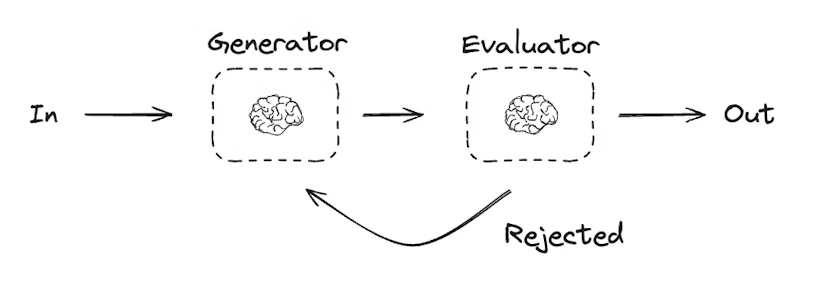

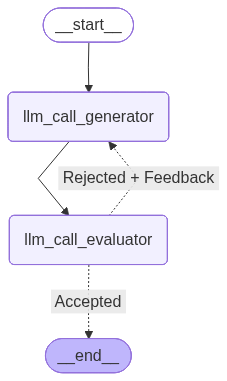

In [20]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))



In [21]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

ValidationError: 1 validation error for Feedback
  Invalid JSON: expected value at line 2 column 1 [type=json_invalid, input_value='\n### Overall Grade: A-\...lliant piece of comedy.', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/json_invalid

# Agent

Agents are typically implemented as an LLM performing actions using tools. They operate in continuous feedback loops, and are used in situations where problems and solutions are unpredictable. Agents have more autonomy than workflows, and can make decisions about the tools they use and how to solve problems. You can still define the available toolset and guidelines for how agents behave.

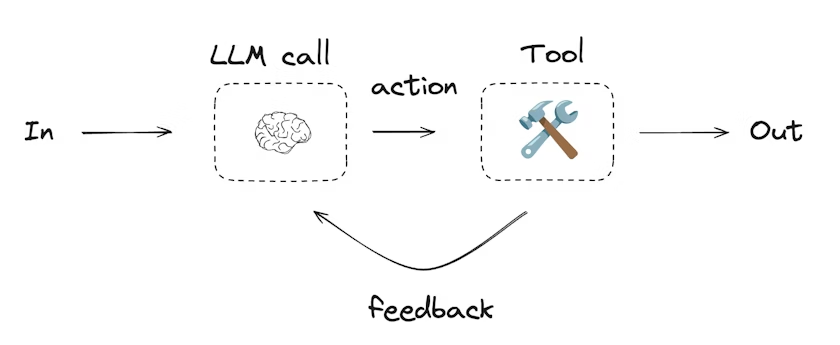

In [22]:
from langchain.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

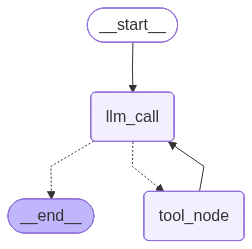

In [23]:
from langgraph.graph import MessagesState
from langchain.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))



In [24]:
# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================


I'll add 3 and 4 for you.
Tool Calls:
  add (call_-8074904892232753072)
 Call ID: call_-8074904892232753072
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================


The result of adding 3 and 4 is 7.
